<a href="https://colab.research.google.com/github/C1PO/Machine_learning/blob/main/cognition%26computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COGNITION & COMPUTATION (A.Y. 2022-2023)

## 1. Introduction
In this Python Notebook, I will use Convolutional Neural Networks (CNN) to classify cifar10 images.
The CIFAR-10 dataset consists of a set of 60,000 color images with a resolution of 32x32 pixels, divided into 10 equally balanced classes (6000 saples each class). Each class represents a specific type of object or animal, such as airplanes, cars, birds, cats, etc.

[CIFAR10](https://www.tensorflow.org/datasets/catalog/cifar10?hl=it).


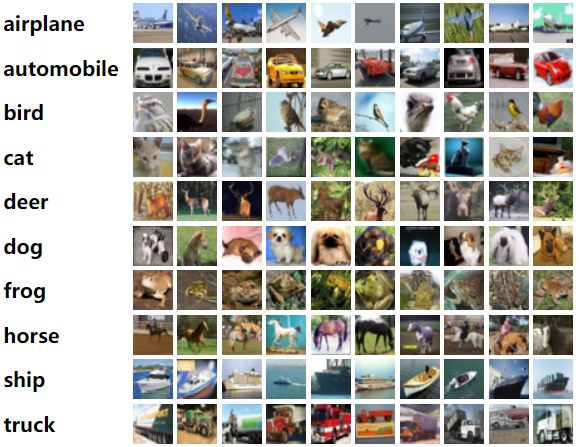

This notebook is divided in some salients points:
In the first part I import all the libraries I need for the project and I import the dataset. Then I process the data in order to give them to the CNN and I evaluate the model on the dataset.
Then I perform linear readout at different level of the model, and visualize the feature maps of the developed model.
To evaluate the robustness of the model, I add Gaussian noise and I see how the CNN responds to small changes in the input.
Finally, I will evaluate the response to adversarial attacks using the Fast Gradient Sign Method (FGSM).
At the end, an autoencoder is trained in order to reconstruct the original images from noisy input and to evaluate that we use the CNN previously created.

## 2. Import the dataset and Data normalization
In this section I import the dataset from [Keras](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data).

I divide the dataset in training (40000 samples), validation (10000 samples), and test set (10000 samples): The train set is used to train the CNN, so to make the model learn the patterns in the data. The validation set is used to adjust the model parameters and to select the best configuration and finally, the test set is  used at the end of the process to assess the accuracy and final performance of the model on unseen data.

Then, I normalize the image data so that each pixel has a value between 0 and 1 (important to improve model stability during training) and I convert the numeric label of each image into a one-hot encoding representation, i.e. a binary representation where each category is represented as a vector of 10 elements with all values ​​set to 0, except the one corresponding to the category which is 1.


In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, plot_model
from os import name
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, AveragePooling2D, Input, UpSampling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
!pip install keract
from keract import get_activations, display_activations
from sklearn.metrics import classification_report, confusion_matrix
import plotly.figure_factory as ff


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Split the dataset in trainig, validation and test set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

170498071/170498071 [==============================] - 13s 0us/step


In [3]:
#ensure that all image pixels are in range between 0 and 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')

x_train = x_train / 255.
x_test = x_test / 255.
x_val = x_val / 255.

In [4]:
# convert the labels to one-hot encoding format
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

In [5]:
print("Samples of the training set:", x_train.shape[0])
print("Samples of the validation set: ", x_val.shape[0])
print("Samples of the test set: ", x_test.shape[0])

Samples of the training set: 40000
Samples of the validation set:  10000
Samples of the test set:  10000


In [6]:
labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

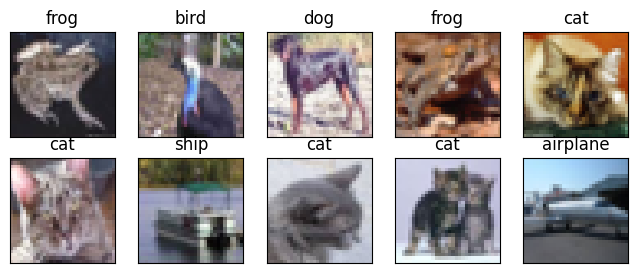

In [7]:
# plot the first 10 images of the training set
fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    ax.imshow(x_train[i])
    ax.set_title(labels[np.argmax(y_train[i])])
plt.show()

## 3. Model definition

In this section I define the Convolutional Neural Network used for the image classification. As we can see the network is composed by 3 blocks with:
* A convolutional layer with 32 filters of dimension 3x3.
* A BatchNormalization layer that is a layer used to normalize the input to each layer of a neural network, specifically to the output of the activation function.
* A convolutional layer with 32 filters of dimension 3x3.
* A BatchNormalization layer
* A maxPooling layer with a pool_size of 2x2: it divides the input data into non-overlapping 2x2 regions, and for each region, outputs the maximum value. This effectively downsamples the spatial dimensions of the input by a factor of 2.
* A Dropout layer: they randomly sets the 20% of the input units to zero. The purpose of the Dropout layer is to prevent overfitting in the network by reducing the dependence of the network.

Then, these layers are followed by:
* a flatten layer that converts the output of the convolution in a one dimension vector.
* A Dropout layer
* A fully connected layer composed of 1024 neurons
* A Dropout layer
* And a fully connected layer composed of 10 neurons is used as output layer by the fact that there are 10 different classes in the dataset.

The network is compiled with a categorical cross-entropy loss function and an Adam optimizer with a learning rate of 0.001.

Before the evaluation of the model I perform data augmentation in order to increase the performance of the CNN.
Finally, the model is evaluated on the test set using the evaluate function, and the test loss and accuracy are printed.
At the end of the section we can see the plot of the accuracy, the loss of the network and the consufion matrix.

In [8]:
#Define the architecture of the CNN

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], name='conv1'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same', name='conv3'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv4'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same', name='conv5'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv6'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu', name='dense1'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax', name='dense2'))

In [9]:
#Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

**Data augmentation** is a technique used to increase the quantity and variety of training data. It involves applying transformations or manipulations to existing data to generate new examples that share the same characteristics but have some variations.
In this case, I perform data augmentation on the training set using the ImageDataGenerator function of Keras. It includes rotating the images, shifting their width and height, and flipping them horizontally. These transformations retain the basic information present in the original images, but introduce realistic variations that allow the model to learn a more robust and general representation of the images.

Than, the augmented data is then used to train the model.

In [10]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

datagen.fit(x_train)

Here I define two callbacks, that are functions called during the training process:
* **Early stopping** is an optimization technique used to reduce overfitting without compromising on model accuracy. Thus, it stops the training process if the validation loss does not improve for a certain number of consecutive epochs.
* **ReduceLROnPlateau** is a technique that dynamically adjusts the learning rate of a model during training. The main purpose of ReduceLROnPlateau is to help the model to converge faster and improve its performance.
It reduces the learning rate of the optimizer if the validation loss does not improve for a certain number of epochs.

In [11]:
# Defining callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0000001)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

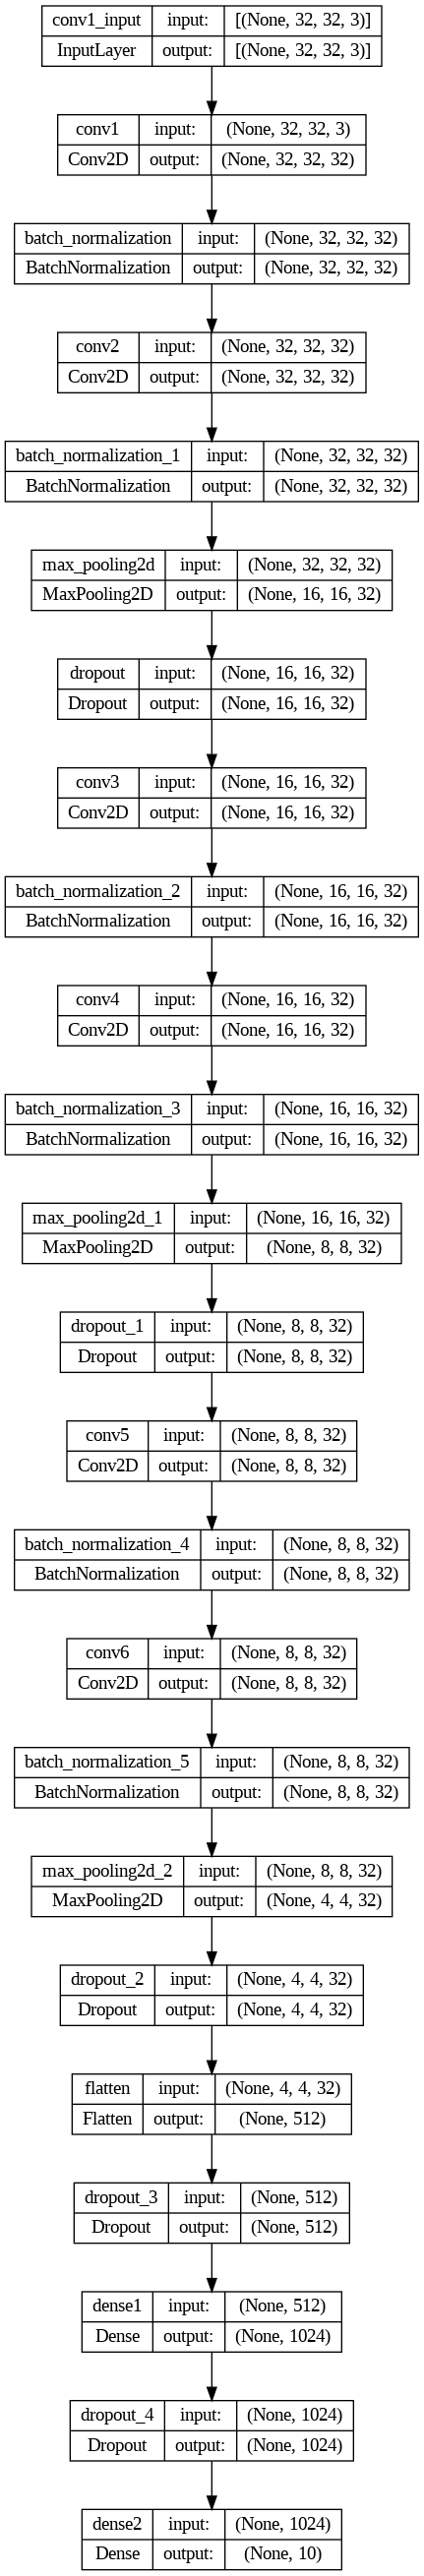

In [13]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [14]:
#Train of the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=30, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/30
625/625 [==============================] - 55s 54ms/step - loss: 1.6380 - accuracy: 0.4148 - val_loss: 1.5434 - val_accuracy: 0.4610 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 27s 43ms/step - loss: 1.3065 - accuracy: 0.5296 - val_loss: 1.1709 - val_accuracy: 0.5885 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 27s 43ms/step - loss: 1.1689 - accuracy: 0.5825 - val_loss: 1.0572 - val_accuracy: 0.6254 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - 28s 44ms/step - loss: 1.0867 - accuracy: 0.6159 - val_loss: 0.9983 - val_accuracy: 0.6477 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 29s 47ms/step - loss: 1.0219 - accuracy: 0.6390 - val_loss: 0.9685 - val_accuracy: 0.6663 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - 27s 44ms/step - loss: 0.9793 - accuracy: 0.6550 - val_loss: 0.9506 - val_accuracy: 0.6689 - lr: 0.0010
Epoch 7/30
625/625 [==============================] - 27s 

KeyboardInterrupt: ignored

In [ ]:
#Print the loss and accuracy
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

The accuracy of the CNN is about 80%.

In [ ]:
#Function that plots the accuracy of a history
def plot_accuracy(history):
  plt.figure(figsize=(8,5))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='lower right')
  plt.show()

In [ ]:
#Function that plots the loss of a history
def plot_loss(history):
  plt.figure(figsize=(8,5))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [ ]:
plot_accuracy(history)

In [ ]:
plot_loss(history)

Let's now see the **confusion matrix** that shows us the number of correct and incorrect predictions for each class.

In [ ]:
#Confusion matrix
y_pred = model.predict(x_test)

y_test_int = np.argmax(y_test, axis=1)
y_pred_int = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test_int, y_pred_int)

fig = ff.create_annotated_heatmap(z=np.array(cm), colorscale='Blues')
fig.update_layout(title='Confusion Matrix')
fig.show()

## 4. Linear read out

By utilizing hidden representations and linear readouts, it becomes possible to inspect how the model processes and interprets the input data, and to evaluate its capacity to learn disentangled representations that are useful for making predictions. By analyzing the hidden representations at various levels of the neural network, we can determine if the model is able to learn progressively more independent and disentangled features in deeper layers, which may result in better performance.

A disentangled representation refers to a type of feature representation where each feature or aspect of the input data is represented by a distinct and uncorrelated set of neurons. This makes it easier for the model to manipulate and reason about these features in a more understandable and efficient manner.
By performing the linear readout, we take the outputs of the three intermediate levels and feed them as input to the corresponding linear model.
Then I calculate the accuracy of these linear models.

First of all we need to extract the hidden representations from the layers:

In [ ]:
#Function that return the output of a given layer
def get_hidden_representation(dataset, layer_name):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_layer_model.predict(dataset)
    return intermediate_output

In [ ]:
#Hidden representation of the fourth layer
conv4_output_train = get_hidden_representation(x_train, 'conv4')
#Hidden representation of the fifth layer
conv5_output_train = get_hidden_representation(x_train, 'conv5')
#Hidden representation of the sixth layer
conv6_output_train = get_hidden_representation(x_train, 'conv6')

In [ ]:
input_shape = conv4_output_train.shape[1:]

# Creating the linear model with the input shape equal to the shape of the output of the conv4 layer
linear_model4 = tf.keras.Sequential([
    Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compiling the model
linear_model4.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Training the model
history_conv4 = linear_model4.fit(conv4_output_train,
                                 y_train,
                                 batch_size=64,
                                 epochs=20)

In [ ]:
input_shape = conv5_output_train.shape[1:]

# Creating the linear model with the input shape equal to the shape of the output of the conv5 layer
linear_model5 = tf.keras.Sequential([
    Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compiling the model
linear_model5.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Training the model
history_conv5 = linear_model5.fit(conv5_output_train,
                                 y_train,
                                 batch_size=64,
                                 epochs=20)

In [ ]:
input_shape = conv6_output_train.shape[1:]

# Creating the linear model with the input shape equal to the shape of the output of the conv6 layer
linear_model6 = tf.keras.Sequential([
    Input(shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compiling the model
linear_model6.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Training the model
history_conv6 = linear_model6.fit(conv6_output_train,
                                 y_train,
                                 batch_size=64,
                                 epochs=20)

In [ ]:
#Plot the loss of the convolutional layers
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(history_conv4.history['loss'], label='conv4 linear readout', linewidth=2)
ax.plot(history_conv5.history['loss'], label='conv5 linear readout', linewidth=2)
ax.plot(history_conv6.history['loss'], label='conv6 linear readout', linewidth=2)

ax.legend(loc='upper right', fontsize=12)

ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)

plt.show()

As we can see from the graph as we go deeper the loss decreases and the accuracy increases. This is because the model gradually learns to make correct classification as it descends in the deepest layer of the architecture.

This behavior is what we expected because it means that the model gradually learns to make correct classification as it descends in the deepest layer of the architecture.

## 4.1 Linear readouts test

Now we use the test set to test the accuracy of each linear readout:

In [ ]:
conv4_output_test = get_hidden_representation(x_test, 'conv4')
conv5_output_test = get_hidden_representation(x_test, 'conv5')
conv6_output_test = get_hidden_representation(x_test, 'conv6')

Let's now compute the accuracy of the linear models just created:

In [ ]:
score_conv4 = linear_model4.evaluate(conv4_output_test, y_test, verbose=0)
print('Test accuracy of the linear model with the input equal to the output of the CNN conv4 layer:', score_conv4[1])

In [ ]:
score_conv5 = linear_model5.evaluate(conv5_output_test, y_test, verbose=0)
print('Test accuracy of the linear model with the input equal to the output of the CNN conv5 layer:', score_conv5[1])

In [ ]:
score_conv6 = linear_model6.evaluate(conv6_output_test, y_test, verbose=0)
print('Test accuracy of the linear model with the input equal to the output of the CNN conv6 layer:', score_conv6[1])

Based on the outcome mentioned above, a characteristic pattern can be observed in the linear output of a CNN. Specifically, the precision of each linear output improves progressively as one delves further into the underlying structure of the network. This indicates that as the CNN progresses through its convolutional layers, it extracts intricate and increasingly meaningful feature maps, enabling more precise categorization. Consequently, it can be inferred that the model effectively operates on the test data and has acquired the ability to generate reasonably precise forecasts.

## 5. Features visualization

The feature maps of a CNN are the intermediate results of processing an image through the various convolutional layers of the network. Each convolutional layer produces a series of feature maps, which represent the features extracted from the image.
They are created by applying a specific filter to the input image and they highlights the areas of the image that the filter is designed to detect. Each feature map shows how the network processes the input and which regions of the image are important for classification.
Each feature map represents a particular aspect of the image, such as lines, contours, textures or objects of a specific shape. By studying feature maps, it is possible to understand which features are detected and how they are represented within the network.

In order to do this I use Keract that is a module which allows us to easily plot the feature maps of the various hidden layers.


In [ ]:
#First image of training
plt.imshow(x_train[0])
plt.show()

In [ ]:
layer_names=['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'dense1', 'dense2']

#get the activations of the first train sample
activations_cnn = get_activations(model, x_train[0:1], layer_names=layer_names)
# show the activations
display_activations(activations_cnn, cmap="viridis")

From the plotted feature maps of the first convolutional layer, we can see how the model highlight different features of the image.
Going deep in the feature map, the filters become less and less significant to the human eyes, since the dimension of the image is reduced, and it shows less and less recognizable details.

## 6. Robustness to Gaussian noise

In this section I add Gaussian noise to the test set in order to see how the model reacts with random noise.

Injecting Gaussian noise in images means adding randomness to the pixel values, in this way each pixel is influenced by the random values of the Gaussian noise.

In [ ]:
print('Accuracy before the noise: {:.2f}%'.format(test_acc * 100))

In [ ]:
#Add Gaussian noise to the test set
def addGaussianNoise(noise_factor):
  x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

  #Force the pixel to assume values between 0 and 1
  x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)
  return x_test_noisy

In [ ]:
#Add a noise factor of 0.01
x_test_noisy = addGaussianNoise(0.01)
noise_loss, noise_acc = model.evaluate(x_test_noisy, y_test, verbose=0)
print('Accuracy after the noise factor of 0.01: {:.2f}%'.format(noise_acc * 100))

In [ ]:
y_pred_noisy = model.predict(x_test_noisy)

In [ ]:
def plot_noised_image():
  #Plot the original image and image with noise
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))

  axs[0].imshow(x_test[0], cmap='gray')
  axs[0].set_title('Original image')

  axs[1].imshow(x_test_noisy[0], cmap='gray')
  axs[1].set_title('Image with noise factor of 0.01')

  for ax in axs:
      ax.axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
plot_noised_image()

In [ ]:
print("True label: ", labels[np.argmax(y_test[0])])
print("Label predicted after the noise (0.01): ", labels[np.argmax(y_pred_noisy[0])])

In [ ]:
#Add a noise factor of 0.05
x_test_noisy = addGaussianNoise(0.05)
noise_loss, noise_acc = model.evaluate(x_test_noisy, y_test, verbose=0)
print('Accuracy after the noise factor of 0.05: {:.2f}%'.format(noise_acc * 100))

In [ ]:
y_pred_noisy = model.predict(x_test_noisy)

In [ ]:
plot_noised_image()

In [ ]:
print("True label: ", labels[np.argmax(y_test[0])])
print("Label predicted after the noise: ", labels[np.argmax(y_pred_noisy[0])])

As we can see, as we add a noise parameter to the images, the accuracy obviously decrease.
With a noise parameter of 0.01 the prediction made by the model is still correct, but increasing the noise factor the same image will be misclassified.
In general, Gaussian noise affect the image, making it less defined. In fact the accuracy level strongly decreases as noise level increase and in the same way the loss increase for higher values of noise.

## 7. Adversarial Attack

An adversarial attack refers to a specialized input designed specifically for a Neural Network with the aim of causing misclassification by the model. In particular, we have implemented one of the most widely used techniques known as the white box **Fast gradient sign method**.
Essentially, FGSM computes the gradients of a loss function with respect to the input image and then uses the sign of the gradients to create the adversarial image. This approach is adopted because the goal is to generate an image that maximizes the loss. To achieve this, a technique is employed to determine the contribution of each pixel in the image to the overall loss value and introduce a perturbation accordingly.
The advantage of this method is its efficiency, as it is relatively straightforward to calculate the impact of each input pixel on the loss using the chain rule and obtaining the necessary gradients. Thus, the gradients are taken with respect to the image itself.
This is the formula of FGSM:

$adv_x = x + \epsilon \cdot \text{sign}(\nabla_{x} J(θ, x, y))$

where:
* $adv_x$ : Adversarial image.
* $x$ : Original input image.
* $y$ : Original input label.
* $\epsilon$ : Multiplier to ensure the perturbations are small.
* $\theta$ : Our neural network model
* $J$: The loss function

Considering the dataset's large size and the limited resources available on Google Colab, I don't execute the FGSM attack on the complete dataset. Instead, I apply the attack to an image with different values of epsilon. This strategy should adequately demonstrate the functionality of the FGSM and assess the resilience of the CNN we previously developed against such attacks.





In [ ]:
# Function that generate a perturbed image given an input image using the Fast Gradient Sign Method
def generate_adversarial_example(input_image, input_label, epsilon):

    input_image = tf.cast(input_image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(input_label, prediction)

    # Calculate the gradients w.r.t. input image
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    perturbation = epsilon * signed_grad

    # Perturbation of the original image
    perturbed_image = input_image + perturbation
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)

    return perturbed_image

In [ ]:
#Plot the perturbed image given as input and the original sample
'''def plot_adversarial_image(x_adv):
  fig, axs = plt.subplots(1, 2)
  axs[0].imshow(x.squeeze(), cmap='viridis')
  axs[0].set_title('Original Example')
  axs[1].imshow(x_adv.numpy().squeeze(), cmap='viridis')
  axs[1].set_title('Adversarial Example')
  plt.show()

  y_pred = model.predict(x)
  y_pred_adv = model.predict(x_adv)

  print('True Label:', labels[y_true])
  print('Predicted label after adversarial attack:', labels[np.argmax(y_pred_adv)])'''

In [ ]:
x = x_test[0]
x = x.reshape(1, 32, 32, 3)
y_true = np.argmax(y_test[0])
#different values of epsilon
epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
perturbated_images=[]
perturbated_labels=[]

#show the image with several epsilon values
for e in epsilons:
  x_adv = generate_adversarial_example(x, y_true, e)
  perturbated_images.append(x_adv)
  y_pred_adv = model.predict(x_adv)
  perturbated_labels.append(labels[np.argmax(y_pred_adv)])

In [ ]:
plt.imshow(x_test[0])
plt.show()
#Plot the images with the different epsilon
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axs[0]):
    ax.imshow(np.squeeze(perturbated_images[i]), cmap='viridis')
    ax.set_title(f"Predicted: {perturbated_labels[i]}\nEpsilon:{epsilons[i]}")
    ax.axis('off')

for i, ax in enumerate(axs[1]):
    ax.imshow(np.squeeze(perturbated_images[i+5]), cmap='viridis')
    ax.set_title(f"Predicted: {perturbated_labels[i + 5]}\nEpsilon:{epsilons[i+5]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

The images appear slightly altered from a human standpoint when using small ϵ values. However, as the ϵ value increases, the distinct elements comprising the images remain recognizable, and the impact of the injection becomes clearly visible.
The attack has been successful, as the model consistently missclassifies the image at each ϵ value.

From these observations, we can deduce that this CNN exhibits a very low resistance against this type of attack.

## 8. Convolutional Autoencoder - CAE

Now, a Convolutional Autoencoder is established for the purpose of executing image denoising. Broadly speaking, an autoencoder is an unsupervised neural network employed to diminish the dimensionality of the input data by acquiring a compressed representation and subsequently reconstructing the initial data based on said compressed representation.

An autoencoder consists of two primary components:

* Encoder: Receives the original image and converts it into a compressed representation.
* Decoder: Takes the output from the encoder and reconstructs the original input utilizing the compressed representation.

In particular, the encoder is made by 2 convolutional layers with 32 and 16 filters of dimension 3×3, followed by 2 max pooling layers in order to reduce the output dimension by a factor of 2.

Similarly, the decoder is made by 2 convolutional layers with the same dimension of the others (16 and 32 filters), followed by 2 layers of up-sampling in order to reconstruct the image. In the end, a convolutional layer with 3 filters of size 3×3 reconstruct the original image.

The autoencoder is then compiled using 'Adam' as optimizer and the loss function 'MeanAbsoluteError' that calculates the mean of the absolute difference between the original image and the reconstructed.

In [ ]:
#Function to create an autoencoder
def create_model():
  input_image = tf.keras.Input(shape=(32, 32, 3))

  #Encoder
  x = Conv2D(32, 3, activation='relu', padding='same', name='encoder_first_conv')(input_image)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(16, 3, activation='relu', padding='same', name='encoder_second_conv')(x)
  encoded = MaxPooling2D(2, padding='same')(x)
  print(encoded.shape)

  #Decoder
  x = Conv2D(16, 3, activation='relu', padding='same',name='decoder_first_conv')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, 3, activation='relu', padding='same',name='decoder_second_conv')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='last_conv')(x)
  autoencoder = tf.keras.Model(input_image, decoded)
  autoencoder.compile(optimizer='adam', loss='mean_absolute_error')
  return autoencoder

autoencoder_layer_names = ['encoder_first_conv','encoder_second_conv','decoder_first_conv','decoder_second_conv','last_conv']

In [ ]:
autoencoder = create_model()

In [ ]:
noise_level = 0.05

#Insert noise in the training set
x_train_noisy = x_train + noise_level * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)

#Insert noise in the validation set
x_val_noisy = x_val + noise_level * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape)

#Force the pixel value to be between 0 and 1
X_train_noisy = np.clip(x_train_noisy, 0., 1.)
X_validation_noisy = np.clip(x_val_noisy, 0., 1.)

To enable the autoencoder training for the purpose of denoising noisy images, I employ the training dataset. In this dataset, I introduce Gaussian noise as an additional feature, while keeping the original clean images as the corresponding labels. This approach allows the encoder to learn a compressed representation of the noisy images and subsequently perform an inverse transformation during the reconstruction process, effectively eliminating the inserted noise.

In [ ]:
#Training the encoder on noisy train set allow it to performs better on noisy images and reconstruct them in a better way
autoencoder_results=autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=False,
                validation_data=(x_val_noisy, x_val)
                )

In [ ]:
 #Store the loss of the training and validation set
training_loss = autoencoder_results.history['loss']
validation_loss = autoencoder_results.history['val_loss']

#Loss history for training and validation
plt.figure(figsize=(10, 8))
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Autoencoder: Absolute Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))
for i in range(1, n + 1):
    # Display Original images
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display perturbed images
    ax = plt.subplot(3, n, i+n)
    plt.imshow(x_test_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i + (2*n))
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
#Make predictions on the decoded_images by the autoencoder
res_test=model.evaluate(decoded_imgs,y_test)

For a noise level of 0.05 on test data, we obtain a low level of accuracy using the CNN to make predictions.
This is a slightly higher result than the one obtained using directly the noisy data to test the CNN with the same noise level: in fact, in that case we obtained an accuracy of 0.3622.

In any case these results cannot be considered a success, in fact the autoencoder is not performing well on this dataset and that probably the best technique to increase the resistance of the CNN is to use a more complex autoencoder architecture or in general other techniques of noise removal.